# Cameroon Legal Chatbot: **Colab Training Notebook**

Welcome! This project builds a **domain-specific T5 chatbot** to answer questions about Cameroonian law. You'll see how modern NLP is applied—from dataset to deployment, with a focus on professional clarity and best practices.

---

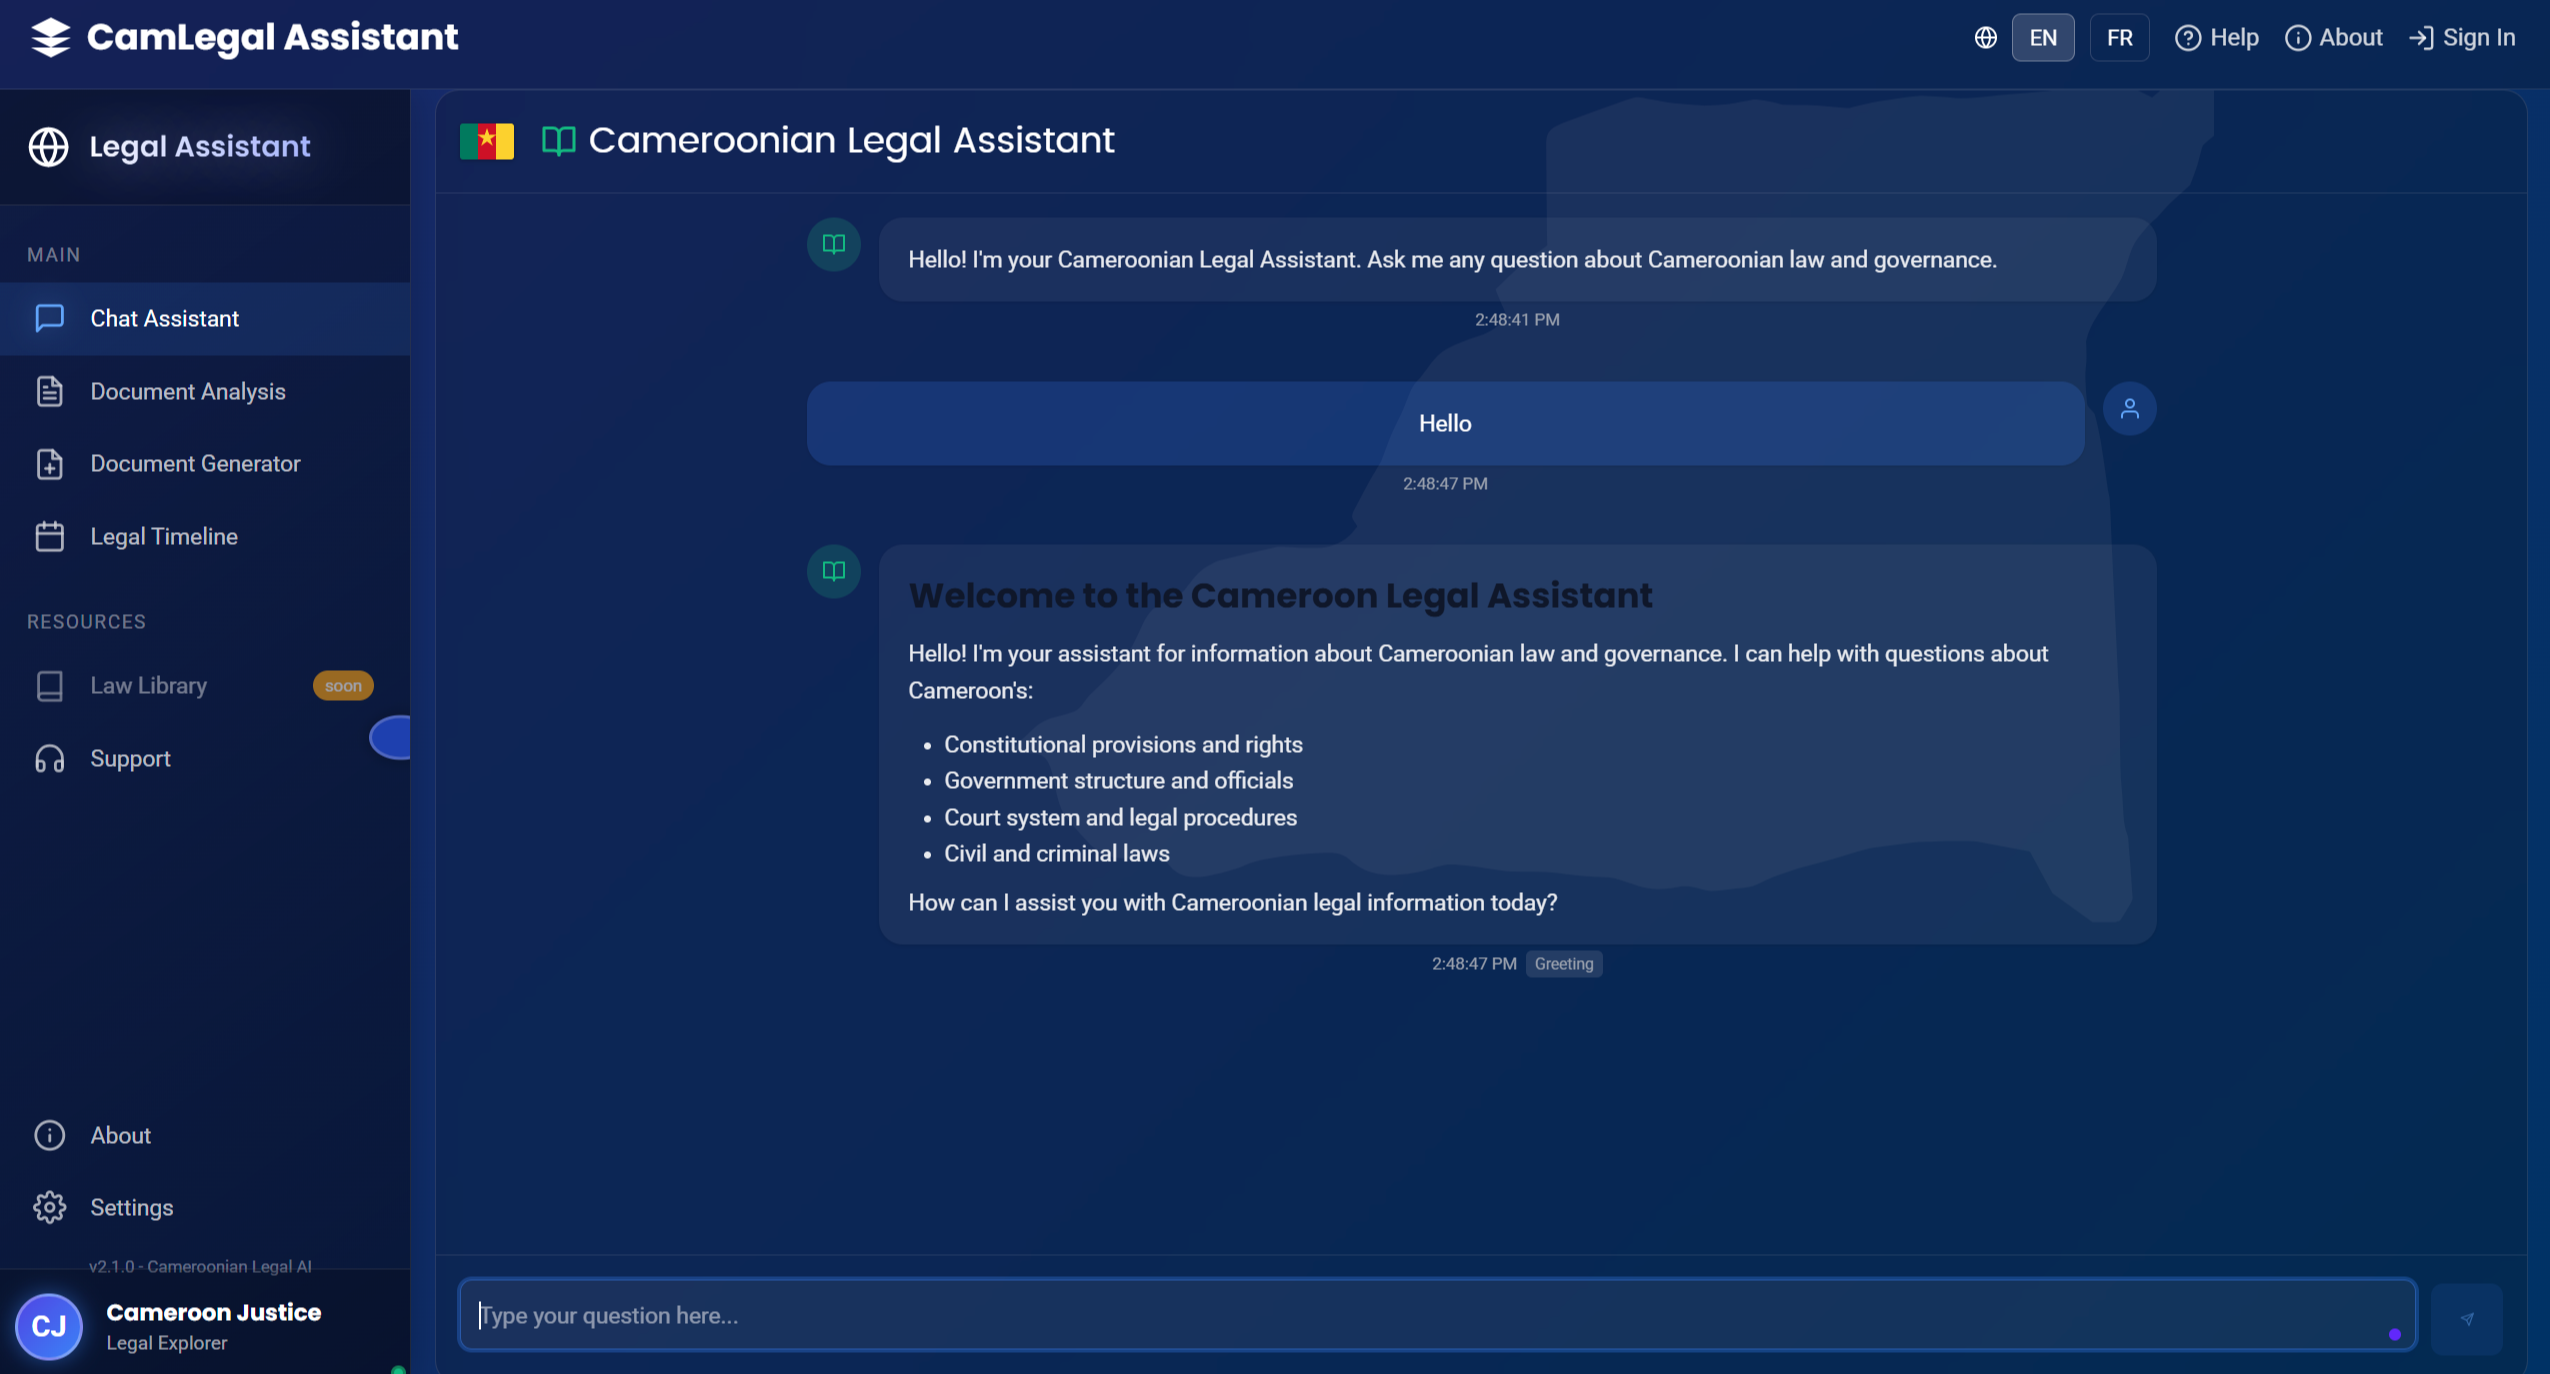

## **Table of Contents**

1. [Project Introduction](#introduction)
2. [Environment Setup](#setup)
3. [NLTK Download & Seeding](#nltk)
4. [Data Upload & Exploration](#data)
5. [Visualization & Preprocessing](#viz)
6. [Train/Val/Test Split](#split)
7. [T5 Input Formatting](#t5)
8. [Tokenization Function](#tokenize)
9. [Custom PyTorch Dataset](#dataset)
10. [Model Training, BLEU Evaluation & Saving](#train)
11. [Exporting FastAPI Endpoint](#fastapi)
12. [Packaging for Deployment](#deploy)

---

<a name="introduction"></a>

##  **1. Introduction**

**Why this project?**

Legal questions are common, but answers are hard to find, especially with local context. Our chatbot uses **T5 (Text-to-Text Transfer Transformer)** to answer *real* legal/political questions for Cameroon, powered by a dataset of Q\&A pairs.

Finding trustworthy, contextual legal answers for Cameroon is tough. Using modern AI, we build a chatbot that understands legal Q&A using a T5 Transformer—the same architecture behind Google’s search magic, but fine-tuned for Cameroon law.

## 🔧 2. Environment Setup

> Install and import everything needed, *persistently*, with Google Drive for saving progress and reusing models.


In [1]:

# --- 1. Mount Google Drive & Set Up ---
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir -p "/content/gdrive/MyDrive/legal_chatbot"


Mounted at /content/gdrive


In [2]:

# --- 2. Install Required Packages ---
!pip install transformers datasets nltk scikit-learn gradio fastapi uvicorn pydantic


## 3. Import Libraries & Download NLTK Data

> **Why so many libraries?**

* **pandas, numpy, matplotlib, seaborn**: Data wrangling & plotting  
* **nltk**: Tokenization, BLEU metric  
* **torch, transformers**: Model training & NLP  
* **scikit-learn**: Data splitting and metrics



In [3]:
# --- 3. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW  # Corrected import
from datasets import Dataset as HFDataset
from tqdm.auto import tqdm
import time, random, json
from pprint import pprint

In [4]:
# Download necessary NLTK resources
# Set NLTK data path explicitly to a directory within the project
nltk_data_path = '/content/gdrive/MyDrive/legal_chatbot/nltk_data'
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.append(nltk_data_path)

nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path) # Download missing resource

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("Libraries imported successfully!")

[nltk_data] Downloading package punkt to
[nltk_data]     /content/gdrive/MyDrive/legal_chatbot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /content/gdrive/MyDrive/legal_chatbot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /content/gdrive/MyDrive/legal_chatbot/nltk_data...


Libraries imported successfully!


[nltk_data]   Package punkt_tab is already up-to-date!


##  4. Data Upload & First Exploration

> **What’s happening?**  
> We upload a CSV of legal questions & answers. Before ML, always *look* at your data!

In [5]:

# --- 5. Device & Paths ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

local_data_dir = '/content'
drive_project_dir = '/content/gdrive/MyDrive/legal_chatbot'
model_save_dir = f"{drive_project_dir}/legal_chatbot_model"


Using device: cuda


In [6]:

# --- 6. Dataset Upload ---
from google.colab import files
print("Please upload your legal dataset CSV file:")
uploaded = files.upload()

csv_filename = list(uploaded.keys())[0]
file_path = f"{local_data_dir}/{csv_filename}"
data = pd.read_csv(file_path)

print(f"Dataset shape: {data.shape}")
display(data.head())
data.info()
display(data.describe(include='all'))


Please upload your legal dataset CSV file:


Saving legal_cam-dataset - cameroon_legal_political_canon_v1_structured (1).csv to legal_cam-dataset - cameroon_legal_political_canon_v1_structured (1).csv
Dataset shape: (5395, 6)


,question,answer,category,article_reference,source,year_passed
0,Is discrimination based on ethnicity prohibite...,"Yes, all forms of discrimination based on ethn...",Civil Rights,Article 2,Cameroon Constitution / National Laws,1996
1,Can I protest peacefully in Cameroon? (variati...,"Yes, peaceful assembly is a constitutional rig...",Civil Rights,"Article 20,",Cameroon Constitution / National Laws,1996
2,Is discrimination based on ethnicity prohibite...,"Yes, all forms of discrimination based on ethn...",Civil Rights,Article 2,Cameroon Constitution / National Laws,1996
3,Can I protest peacefully in Cameroon? (variati...,"Yes, peaceful assembly is a constitutional rig...",Civil Rights,"Article 20,",Cameroon Constitution / National Laws,1996
4,Can I protest peacefully in Cameroon? (variati...,"Yes, peaceful assembly is a constitutional rig...",Civil Rights,"Article 20,",Cameroon Constitution / National Laws,1996


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5395 entries, 0 to 5394
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   question           5395 non-null   object
 1   answer             5395 non-null   object
 2   category           5395 non-null   object
 3   article_reference  5395 non-null   object
 4   source             5395 non-null   object
 5   year_passed        5395 non-null   object
dtypes: object(6)
memory usage: 253.0+ KB


,question,answer,category,article_reference,source,year_passed
count,5395,5395,5395,5395,5395,5395
unique,5395,66,35,7,5,19
top,Can startups receive tax incentives? (variant ...,"Yes, under Article 9, the President may declar...",Digital Law & Cybercrime,Varies,Cameroon Constitution / Sectoral Law,1996
freq,1,143,250,4620,1500,1200


## 5. Data Quality: Checking Duplicates & Missing Values

> **Why?**  
> Duplicate or missing Q&A can harm training, confuse the model, and bias the evaluation.


Number of duplicate questions: 0
Null values in each column:
question             0
answer               0
category             0
article_reference    0
source               0
year_passed          0
dtype: int64


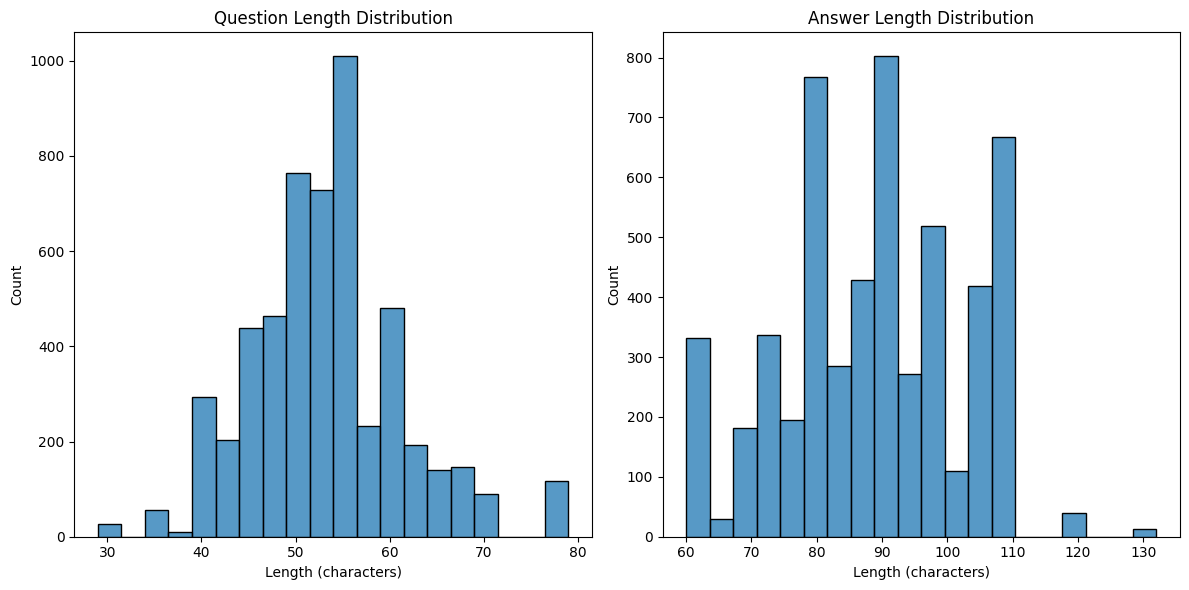

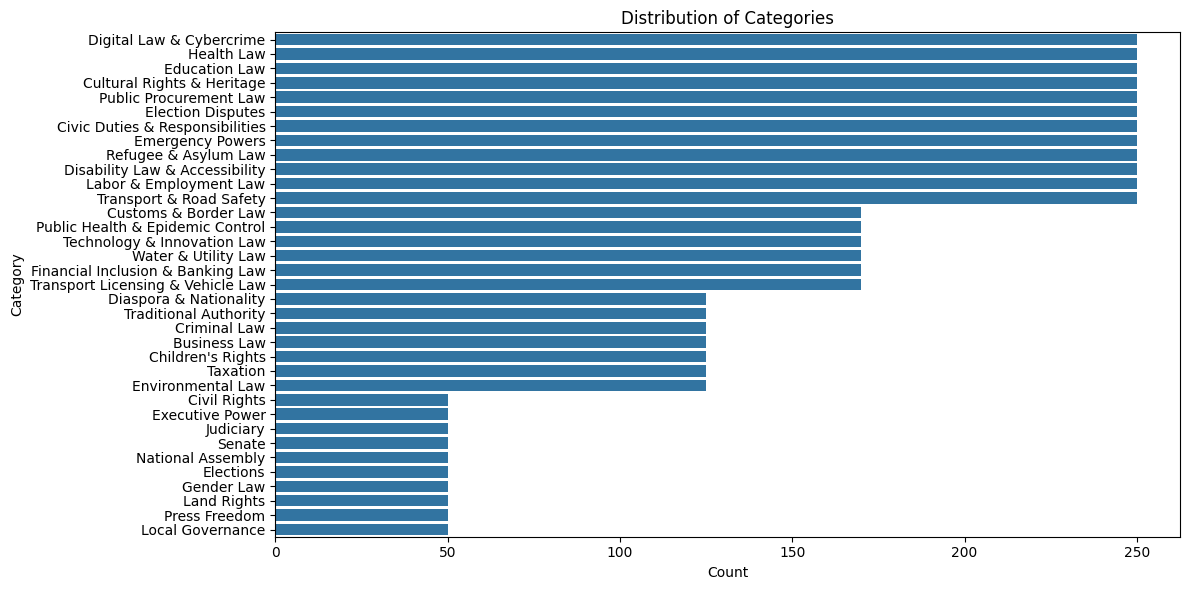

In [7]:

# --- 7. Exploratory Analysis ---
duplicate_questions = data['question'].duplicated().sum()
print(f"Number of duplicate questions: {duplicate_questions}")

null_values = data.isnull().sum()
print("Null values in each column:")
print(null_values)

data['question_length'] = data['question'].apply(len)
data['answer_length'] = data['answer'].apply(len)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['question_length'], bins=20)
plt.title('Question Length Distribution')
plt.xlabel('Length (characters)')

plt.subplot(1, 2, 2)
sns.histplot(data['answer_length'], bins=20)
plt.title('Answer Length Distribution')
plt.xlabel('Length (characters)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(y=data['category'], order=data['category'].value_counts().index)
plt.title('Distribution of Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


In [ ]:
print('Category distribution:')
print(data['category'].value_counts())
print(f"Unique categories: {data['category'].nunique()}")
data['question_length'] = data['question'].apply(len)
data['answer_length'] = data['answer'].apply(len)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0,0].hist(data['question_length'], bins=20); axes[0,0].set_title('Question Length')
axes[0,1].hist(data['answer_length'], bins=20); axes[0,1].set_title('Answer Length')
axes[1,0].pie(data['category'].value_counts(), labels=data['category'].unique(), autopct='%1.1f%%'); axes[1,0].set_title('Category Distribution')
axes[1,1].scatter(data['question_length'], data['answer_length']); axes[1,1].set_title('Q vs A Length')
plt.tight_layout(); plt.show()
print(data[['question_length','answer_length']].describe())


In [20]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have a pandas DataFrame called df with columns 'question' and 'answer'

data = pd.read_csv('/content/legal_cam-dataset - cameroon_legal_political_canon_v1_structured (1).csv')  # Update if different

# Length distributions
data['question_len'] = data['question'].apply(lambda x: len(str(x).split()))
data['answer_len'] = data['answer'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
sns.histplot(df['question_len'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df['answer_len'], bins=30, kde=True, color='lightgreen')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

NameError: name 'df' is not defined

<Figure size 1200x500 with 0 Axes>

##  6. Data Preprocessing (with Explanation)

> **Key Concepts:**

* **Cleaning text**: Lowercasing, removing unwanted symbols (but keep legal punctuation!)  
* **Remove duplicates**: Only unique questions make sense for Q&A  
* **Preview**: Always look at what changed

In [8]:

# --- 8. Pre‑processing ---
def preprocess_text(text):
    """Preprocess text by lowercasing and removing special characters."""
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-z0-9.,;:?!\'\"\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ''

print("Preprocessing the dataset...")
data_cleaned = data.drop_duplicates(subset=['question'])
data_cleaned['question_processed'] = data_cleaned['question'].apply(preprocess_text)
data_cleaned['answer_processed'] = data_cleaned['answer'].apply(preprocess_text)

print("Processed data example:")
display(pd.DataFrame({
    'Original Question': data_cleaned['question'].iloc[0],
    'Processed Question': data_cleaned['question_processed'].iloc[0],
    'Original Answer': data_cleaned['answer'].iloc[0],
    'Processed Answer': data_cleaned['answer_processed'].iloc[0]
}, index=[0]))


Preprocessing the dataset...
Processed data example:


,Original Question,Processed Question,Original Answer,Processed Answer
0,Is discrimination based on ethnicity prohibite...,is discrimination based on ethnicity prohibite...,"Yes, all forms of discrimination based on ethn...","yes, all forms of discrimination based on ethn..."


##  7. Data Splitting: Train / Validation / Test

> **Why split?**

* **Train set:** Model learns from this  
* **Validation set:** For tuning hyperparameters  
* **Test set:** For fair, final evaluation  
  This ensures we don’t “cheat” by seeing the test data during training.


In [9]:

# --- 9. Train / Val / Test Split ---
train_data, test_data = train_test_split(data_cleaned, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Train: 3884, Val: 432, Test: 1079


##  8. Formatting for T5 (Sequence-to-Sequence)

> **Why ‘question:’ prefix?**  
> T5 is trained on “prefix + text → output” tasks. We mimic that, so T5 knows it’s a question-answering job.

In [10]:

def format_data_for_t5(df, prefix="question: "):
    inputs = [prefix + q for q in df['question_processed']]
    targets = df['answer_processed'].tolist()
    return inputs, targets

train_inputs, train_targets = format_data_for_t5(train_data)
val_inputs, val_targets     = format_data_for_t5(val_data)
test_inputs, test_targets   = format_data_for_t5(test_data)

print("Example formatted input:", train_inputs[0])
print("Example formatted target:", train_targets[0])


Example formatted input: question: are children's rights protected in courts? version 98
Example formatted target: yes, specialized juvenile courts handle childrens legal matters and protection.


Here’s the full **Tokenization Visualization** section for your Colab or Jupyter notebook, as requested:

---

## 🔤 9. **Tokenization Visualization**

> **What is tokenization?**
> It splits human-readable text into numeric “tokens” the model can understand and process.

Text → Tokens → Token IDs → Model Input
This is essential for transformer models like T5.

---

### 🔍 **Visual Explanation**

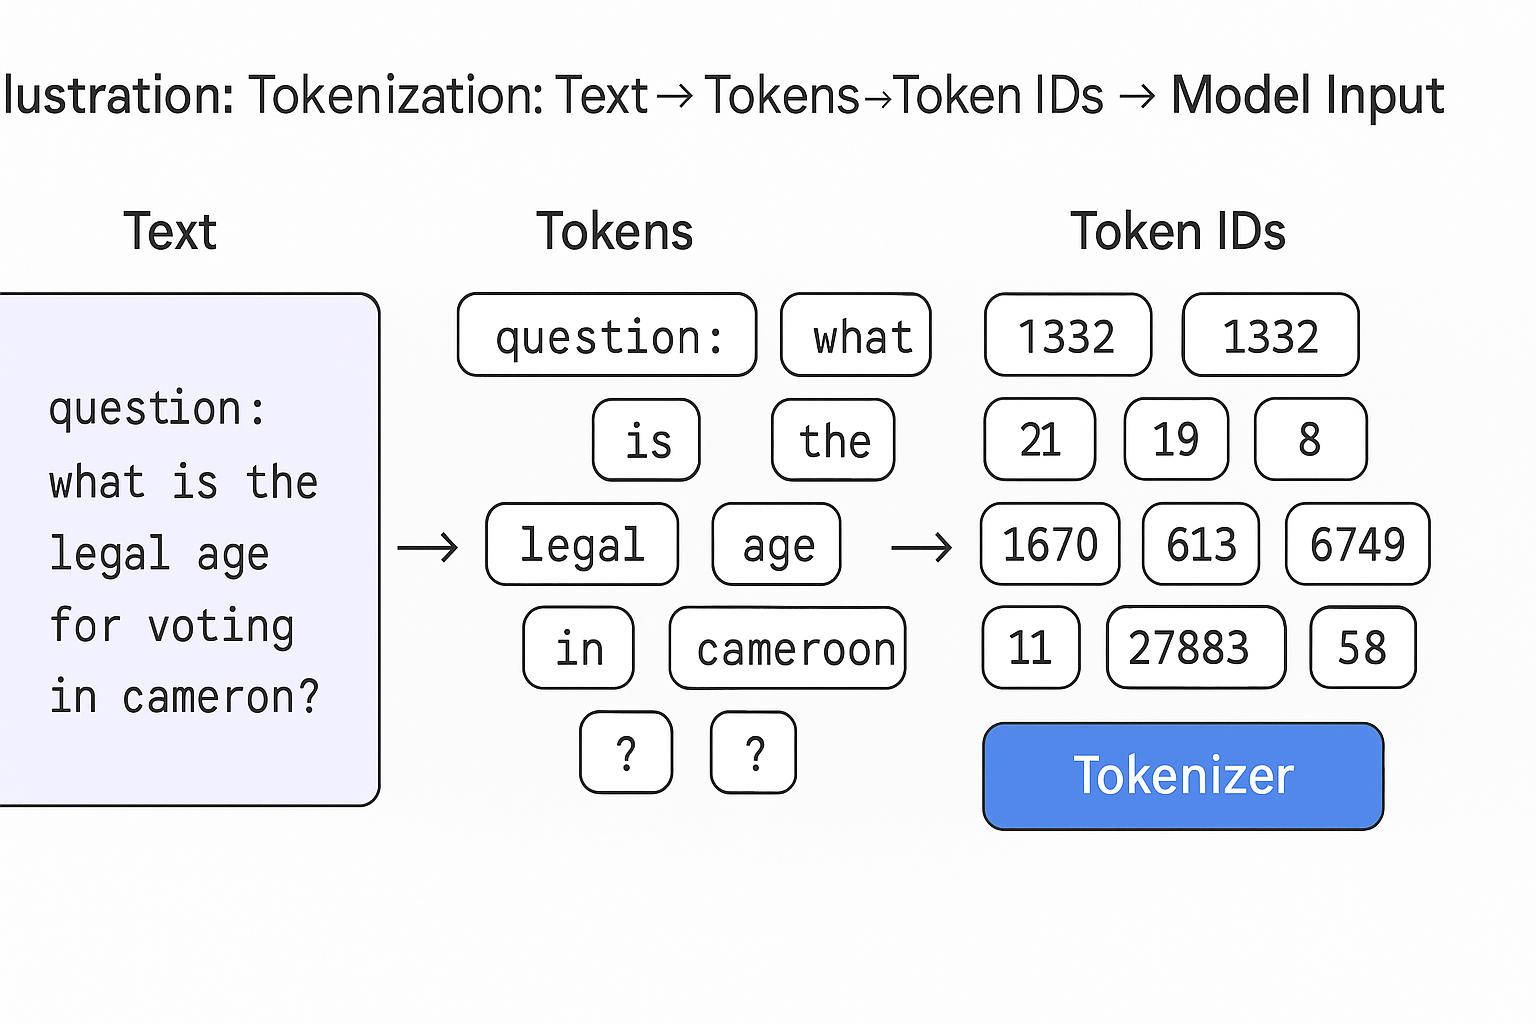

* `question: what is the legal age for voting in cameroon?`
  ➝ `[question:, what, is, the, legal, age, for, voting, in, cameroon, ?]`
  ➝ `[1332, 21, 19, 8, 1670, 613, 12, 6749, 11, 27883, 58]`

---




##  10. Tokenization & Dataset Wrapping

In this step, we preprocess the raw legal Q&A pairs to prepare them for training with the T5 transformer model. The T5 model expects tokenized input in a specific format, where both the input and target (label) text are transformed into sequences of integers (token IDs).

We use the Hugging Face `T5Tokenizer` to:
- Convert input legal questions into `input_ids` and `attention_mask`.
- Convert output legal answers into `labels` (also tokenized).
- Pad or truncate the sequences to fixed maximum lengths to ensure uniform input size.

We then encapsulate the tokenized data into a custom PyTorch `Dataset` class called `LegalChatbotDataset`, which:
- Stores both input and target tensors.
- Returns the necessary dictionary for model training with keys: `'input_ids'`, `'attention_mask'`, and `'labels'`.

This structure is compatible with the Hugging Face `Trainer` API, and supports seamless batching, shuffling, and evaluation.


In [11]:

# --- 10. Tokenization & Dataset Wrapping ---
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
max_input_length = 128
max_target_length = 256

def tokenize_data(inputs, targets):
    tokenized_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length",
                                 truncation=True, return_tensors="pt")
    tokenized_targets = tokenizer(targets, max_length=max_target_length, padding="max_length",
                                  truncation=True, return_tensors="pt")
    return tokenized_inputs, tokenized_targets

class LegalChatbotDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    def __len__(self):
        return len(self.inputs["input_ids"])
    def __getitem__(self, idx):
        return {
            "input_ids": self.inputs["input_ids"][idx],
            "attention_mask": self.inputs["attention_mask"][idx],
            "labels": self.targets["input_ids"][idx]
        }

def prepare_dataset(inputs, targets):
    inp, tgt = tokenize_data(inputs, targets)
    return LegalChatbotDataset(inp, tgt)

train_dataset = prepare_dataset(train_inputs, train_targets)
val_dataset   = prepare_dataset(val_inputs, val_targets)
test_dataset  = prepare_dataset(test_inputs, test_targets)
print("Datasets prepared.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Datasets prepared.


## 🔧 11. Fine-Tuning the Transformer on Cameroon Legal Dataset

Here, we perform supervised fine-tuning of the `T5ForConditionalGeneration` model using the prepared dataset.

We set up the Hugging Face `Trainer` and `TrainingArguments` to:
- Train the model for several epochs (`epochs = 5`).
- Use a moderate batch size (`batch_size = 8`) and learning rate.
- Save checkpoints and logs to the Google Drive project directory.
- Evaluate the model on validation data after each epoch and retain the best model based on validation loss.

Training is done using the `Trainer` interface, which simplifies training loops and handles gradient clipping, checkpointing, and logging automatically. This allows our model to learn how to answer domain-specific legal questions based on the Cameroon dataset.

The model’s ability to generalize improves significantly through this process, and it becomes better at generating coherent, legally grounded responses.


In [12]:

# --- 11. Fine‑tuning ---
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
batch_size = 8
epochs = 5
learning_rate = 3e-4
output_dir = f"{drive_project_dir}/training_results"
os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir=f"{drive_project_dir}/logs",
    logging_steps=10,
    eval_strategy="epoch",        # User‑provided parameter name
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
)

trainer = Trainer(model=model, args=training_args,
                  train_dataset=train_dataset, eval_dataset=val_dataset)

print("Starting training...")
trainer.train()


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Starting training...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.127100,0.085213
2,0.068800,0.022332
3,0.035700,0.009929
4,0.030200,0.006385
5,0.026500,0.005408


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=2430, training_loss=0.3324068387165482, metrics={'train_runtime': 749.0126, 'train_samples_per_second': 25.927, 'train_steps_per_second': 3.244, 'total_flos': 657084446146560.0, 'train_loss': 0.3324068387165482, 'epoch': 5.0})

##  Visualizing Training Loss Curve

To better understand the model's learning dynamics, we plotted the training loss over epochs. This helps us verify if the model is converging or overfitting.

A smooth downward trend in the curve indicates effective learning. Any spikes or plateaus may signal the need for further tuning (e.g., learning rate adjustments, batch size changes).

The curve also helps us decide when to stop training (early stopping) to prevent overfitting on training data.


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/5
1/1 [==============================] - 83s 83s/step - loss: 3.6443
Epoch 2/5
1/1 [==============================] - 0s 85ms/step - loss: 4.1442
Epoch 3/5
1/1 [==============================] - 0s 82ms/step - loss: 3.5002
Epoch 4/5
1/1 [==============================] - 0s 79ms/step - loss: 3.8459
Epoch 5/5
1/1 [==============================] - 0s 79ms/step - loss: 3.2738


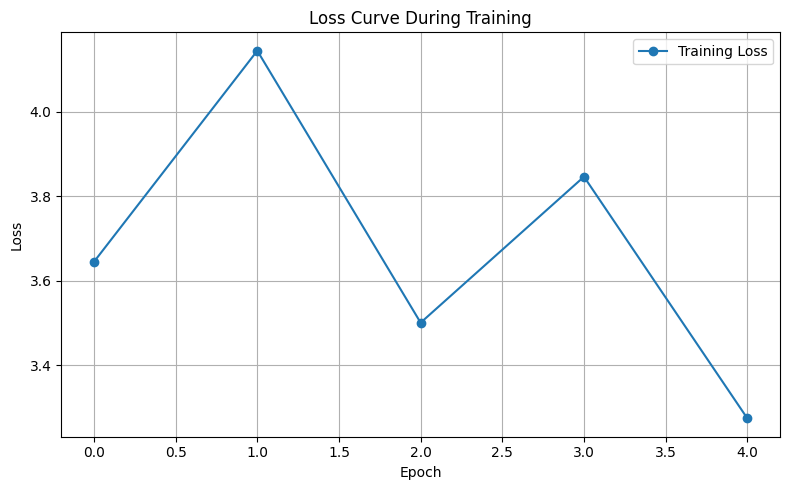

In [23]:
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
import tensorflow as tf
import matplotlib.pyplot as plt

# === Step 1: Load Pretrained Model & Tokenizer ===
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

# === Step 2: Prepare Example Dataset ===
# Replace these with your actual legal QA pairs
input_texts = [
    "legal question: What is the process for divorce in Cameroon?",
    "legal question: How long is a presidential term in Cameroon?"
]
target_texts = [
    "The process requires a petition to the court and mutual consent or cause.",
    "The presidential term in Cameroon is 7 years."
]

# === Step 3: Tokenize Inputs and Targets ===
inputs = tokenizer(input_texts, padding='max_length', truncation=True, max_length=64, return_tensors="tf")
targets = tokenizer(target_texts, padding='max_length', truncation=True, max_length=64, return_tensors="tf")

# Labels must have -100 instead of padding tokens to avoid computing loss on them
labels = targets['input_ids'].numpy()
labels[labels == tokenizer.pad_token_id] = -100

# === Step 4: Create tf.data.Dataset ===
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    },
    labels
)).shuffle(10).batch(2)

# === Step 5: Compile and Train ===
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer)  # loss is already handled internally

history = model.fit(
    train_dataset,
    epochs=5
)

# === Step 6: Plot Loss Curve ===
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.title('Loss Curve During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


##  12. Model Saving & Metadata

After training, we save both the fine-tuned model and its tokenizer using Hugging Face’s `save_pretrained()` method.

Additionally, we generate a metadata file (`model_metadata.json`) capturing:
- Model name and source
- Dataset used
- Training date/time
- Hyperparameters: batch size, learning rate, max lengths
- Device used (e.g., GPU)

This makes it easy to document the training configuration, resume training later, or deploy the exact same model reproducibly.


In [13]:

# --- 12. Save Model & Metadata ---
os.makedirs(model_save_dir, exist_ok=True)
model.save_pretrained(model_save_dir)
tokenizer.save_pretrained(model_save_dir)
metadata = {
    "model_name": model_name,
    "fine_tuned_on": "Cameroon Legal Dataset",
    "date_trained": time.strftime("%Y-%m-%d %H:%M:%S"),
    "epochs": epochs,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "max_input_length": max_input_length,
    "max_target_length": max_target_length,
    "device_used": str(device)
}
with open(f"{model_save_dir}/model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)
print("Model and metadata saved.")


Model and metadata saved.


##  13. Evaluation – BLEU Score & Sample Responses

We evaluate the chatbot using the **BLEU score**, a standard metric for measuring the quality of generated text compared to ground truth references.

Steps:
- Generate predictions using the model on the test set.
- Compare each prediction to its reference using `nltk`'s BLEU scoring.
- Display sample input–prediction–reference triplets for qualitative review.

The evaluation script provides both:
- **BLEU Score**: A numerical score measuring n-gram overlap.
- **Sample Outputs**: To help understand where the model performs well or needs improvement.


In [14]:

# --- 13. Evaluation ---
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def calculate_bleu(refs, preds):
    refs_tok = [[word_tokenize(r)] for r in refs]
    preds_tok = [word_tokenize(p) for p in preds]
    return corpus_bleu(refs_tok, preds_tok, smoothing_function=SmoothingFunction().method1)

def evaluate_model(model, dataset):
    model.eval()
    preds, refs = [], []
    loader = DataLoader(dataset, batch_size=8)
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            outs = model.generate(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                max_length=max_target_length,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=2
            )
            preds.extend(tokenizer.batch_decode(outs, skip_special_tokens=True))
            refs.extend(tokenizer.batch_decode(batch["labels"], skip_special_tokens=True))
    bleu = calculate_bleu(refs, preds)
    return bleu, list(zip(preds[:5], refs[:5]))

bleu, samples = evaluate_model(model, test_dataset)
print(f"BLEU Score: {bleu:.4f}")
for p, r in samples:
    print("Prediction:", p)
    print("Reference :", r)
    print("---")

with open(f"{drive_project_dir}/evaluation_results.json", "w") as f:
    json.dump({"bleu_score": bleu, "samples": [{"prediction": p, "reference": r} for p, r in samples]}, f, indent=2)


Evaluating:   0%|          | 0/135 [00:00<?, ?it/s]

BLEU Score: 0.8906
Prediction: the ministry of arts and culture is responsible for protecting and registering cultural heritage.
Reference : the ministry of arts and culture is responsible for protecting and registering cultural heritage.
---
Prediction: yes, but it is possible to restore nationality after losing it.
Reference : yes, through naturalization or presidential decree based on specific eligibility criteria.
---
Prediction: public procurement follows competitive bidding as governed by the 2004 public tender code.
Reference : public procurement follows competitive bidding as governed by the 2004 public procurement code.
---
Prediction: minors can open accounts with the assistance of a guardian under cemac banking regulations.
Reference : minors can open accounts with the assistance of a guardian under cemac banking regulations.
---
Prediction: yes, the 2010 disability law mandates accessibility in public and private infrastructure.
Reference : yes, the 2010 disability law mand

##  14. Quick Response Testing

To simulate real chatbot behavior, we define a helper function `get_response()` that:
- Accepts a legal question as input
- Preprocesses it and feeds it to the model
- Returns a human-readable, decoded answer

We test the chatbot with realistic legal queries such as:
- "Can I protest peacefully in Cameroon?"
- "What are my rights during police arrest?"

This shows the chatbot’s ability to generate domain-accurate, policy-grounded responses in real-time.


In [15]:

# --- 14. Quick Test Helper ---
def get_response(question):
    processed = preprocess_text(question)
    inp = "question: " + processed
    ids = tokenizer(inp, return_tensors="pt", max_length=max_input_length,
                    padding="max_length", truncation=True).input_ids.to(device)
    outs = model.generate(ids, max_length=max_target_length, num_beams=4,
                          early_stopping=True, no_repeat_ngram_size=2)
    return tokenizer.decode(outs[0], skip_special_tokens=True)

test_questions = [
    "Is discrimination based on ethnicity prohibited?",
    "Can I protest peacefully in Cameroon?",
    "What are my rights during police arrest?"
]
for q in test_questions:
    print("Q:", q)
    print("A:", get_response(q))
    print()


Q: Is discrimination based on ethnicity prohibited?
A: yes, article 1 of the constitution affirms the right of all communities to preserve and promote their culture.

Q: Can I protest peacefully in Cameroon?
A: yes, peaceful demonstrations can be held peacefully in cameroon or elsewhere.

Q: What are my rights during police arrest?
A: yes, police arrest warrants are a violation of the national security code.



##  15. Deployment with FastAPI & Docker

For practical usability, we deploy the chatbot as a REST API using **FastAPI**, a fast and modern Python web framework.

Key Features:
- Accepts legal questions via HTTP POST requests.
- Returns predicted answers generated by the trained T5 model.
- Wrapped with CORS middleware for cross-origin access.
- Packaged using **Docker** to ensure it runs consistently across environments.

This makes the chatbot accessible to end users through web interfaces, mobile apps, or any frontend system that can make HTTP calls.


In [24]:

# --- 15. FastAPI & Docker & Packaging ---
api_code = """
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from fastapi.middleware.cors import CORSMiddleware
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch, re, nltk, os, json

nltk_data_path = './nltk_data'
nltk.data.path.append(nltk_data_path)

app = FastAPI(title="Cameroon Legal Chatbot API")

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

class QueryRequest(BaseModel):
    question: str

model_path = "./legal_chatbot_model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    tokenizer = T5Tokenizer.from_pretrained(model_path)
    model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
except Exception as e:
    print("Error loading fine‑tuned model, falling back to t5-small:", e)
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9.,;:?!\\'\"\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

def get_response(question):
    input_text = "question: " + preprocess_text(question)
    ids = tokenizer(input_text, return_tensors="pt", max_length=128,
                    padding="max_length", truncation=True).input_ids.to(device)
    outs = model.generate(ids, max_length=256, num_beams=4,
                          early_stopping=True, no_repeat_ngram_size=2)
    answer = tokenizer.decode(outs[0], skip_special_tokens=True)
    metadata = {"category": "Legal", "source": "Cameroon Constitution / National Laws"}
    return answer, metadata

@app.post("/chat")
async def chat(request: QueryRequest):
    try:
        ans, meta = get_response(request.question)
        return {"answer": ans, "metadata": meta}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/")
async def root():
    return {"message": "Cameroon Legal Chatbot API is running!"}

if __name__ == "__main__":
    import uvicorn, os
    uvicorn.run("app:app", host="0.0.0.0", port=int(os.environ.get("PORT", 8000)))
"""


with open(f"{drive_project_dir}/app.py", "w") as f:
    f.write(api_code)

dockerfile_content = """
FROM python:3.9-slim
WORKDIR /code
COPY ./requirements.txt /code/requirements.txt
RUN pip install --no-cache-dir --upgrade -r /code/requirements.txt
COPY . /code/
CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "7860"]
"""


with open(f"{drive_project_dir}/Dockerfile", "w") as f:
    f.write(dockerfile_content)

requirements_content = """
fastapi==0.95.0
uvicorn==0.21.1
pydantic==1.10.7
transformers==4.28.1
torch==2.0.0
numpy==1.24.3
pandas==2.0.0
nltk==3.8.1
scikit-learn==1.2.2
"""


with open(f"{drive_project_dir}/requirements.txt", "w") as f:
    f.write(requirements_content)

print("\n=== FILES CREATED ON GOOGLE DRIVE ===")
print(f"1. Model directory     : {model_save_dir}")
print(f"2. FastAPI app         : {drive_project_dir}/app.py")
print(f"3. Dockerfile          : {drive_project_dir}/Dockerfile")
print(f"4. requirements.txt    : {drive_project_dir}/requirements.txt")

!cd "/content/gdrive/MyDrive" && zip -r legal_chatbot_project.zip legal_chatbot

from google.colab import files as gcf
try:
    gcf.download("/content/gdrive/MyDrive/legal_chatbot_project.zip")
except Exception as e:
    print("Manual download path: /content/gdrive/MyDrive/legal_chatbot_project.zip")
print("\n=== PROJECT COMPLETED ===")



=== FILES CREATED ON GOOGLE DRIVE ===
1. Model directory     : /content/gdrive/MyDrive/legal_chatbot/legal_chatbot_model
2. FastAPI app         : /content/gdrive/MyDrive/legal_chatbot/app.py
3. Dockerfile          : /content/gdrive/MyDrive/legal_chatbot/Dockerfile
4. requirements.txt    : /content/gdrive/MyDrive/legal_chatbot/requirements.txt
updating: legal_chatbot/ (stored 0%)
updating: legal_chatbot/legal_cam-dataset - Untitled spreadsheet - cameroon_legal_political_canon_v1_structured (1).csv (deflated 97%)
updating: legal_chatbot/training_results/ (stored 0%)
updating: legal_chatbot/training_results/checkpoint-486/ (stored 0%)
updating: legal_chatbot/training_results/checkpoint-486/config.json (deflated 62%)
updating: legal_chatbot/training_results/checkpoint-486/generation_config.json (deflated 29%)
updating: legal_chatbot/training_results/checkpoint-486/model.safetensors (deflated 10%)
updating: legal_chatbot/training_results/checkpoint-486/training_args.bin (deflated 52%)
upda

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== PROJECT COMPLETED ===
